In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# data handling
import geopandas as gpd
import pandas as pd
import numpy as np
import utils

# data analysis
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, f1_score



import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pathlib
import os


#################### SET GPU ####################
print("tf.__version__:", tf.__version__)

physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
# print(device_lib.list_local_devices())
tf.config.experimental.set_memory_growth(physical_devices[0], True)

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

AUTOTUNE = tf.data.AUTOTUNE


#################### CONFIG ####################
import yaml
from yaml.loader import SafeLoader


with open('CNN_config.yaml') as f:
    config = yaml.load(f, Loader=SafeLoader)

print("CNN_config:\n",config)

tf.__version__: 2.10.1
Num GPUs Available:  1
CNN_config:
 {'BUFFER_SIZE': 100000, 'BATCH_SIZE': 32768}


In [3]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}

# Read csvs
print("--- read .csv files ---")
train_df = gpd.read_file('train.geojson', index_col=0)

test_df = gpd.read_file('test.geojson', index_col=0)

--- read .csv files ---


In [4]:
print("--- Feature engineering ---")

def get_features_sequence(df):
    dic_features = {"names":[],"features":[]}

    # dates/images features
    def get_sorted_date_diff_with_indices(df):
        dates_to_add = []
        for i in range(5):
            date = df[f'date{i}'].apply(lambda x: int(str(x)[-4:]) if x is not None else 0)
            date = np.asarray(date)
            date = np.expand_dims(date,axis=-1)
            dates_to_add.append(date)

        dates = np.concatenate(dates_to_add,axis=-1)

        indices_dates = np.argsort(dates,axis=-1)
        dates = np.array([dates[i,indices_dates[i,:]] for i in range(dates.shape[0])])

        date_diff = dates - dates[:,-1:]@np.ones((1,5),dtype=int)
        return date_diff, indices_dates

    date_diff,indices_dates=get_sorted_date_diff_with_indices(df)
    # dic_features["features"].append(date_diff)
    # dic_features["names"]+=[f"new_date_diff{i}" for i in range(5)]

    # colors
    trad_colors = {"red":0,"blue":1,"green":2}
    def get_mean_std(df):
        colors = list(trad_colors.keys())
        res = np.zeros((df.shape[0],5,3,2))
        for i in range(1,6):
            for j_color,color in enumerate(colors):
                res[:,i-1,j_color,0] = np.asarray(df[f"img_{color}_mean_date{i}"])
                res[:,i-1,j_color,0] = np.nan_to_num(res[:,i-1,j_color,0], nan=np.nanmean(res[:,i-1,j_color,0]))
                res[:,i-1,j_color,1] = np.asarray(df[f"img_{color}_std_date{i}"])
                res[:,i-1,j_color,1] = np.nan_to_num(res[:,i-1,j_color,1], nan=np.nanmean(res[:,i-1,j_color,1]))
        return res

    color_mean_std = get_mean_std(df)
    color_mean_std = np.array([color_mean_std[i,indices_dates[i,:],:,:] for i in range(color_mean_std.shape[0])])
    color_mean_std = np.concatenate([color_mean_std[:,:,:,i] for i in range(color_mean_std.shape[-1])],axis=-1)

    dic_features["features"].append(color_mean_std)
    dic_features["names"]+=[f"color_mean_{i}" for i in range(3)]
    dic_features["names"]+=[f"color_std_{i}" for i in range(3)]


    # change statuses
    le_change_status = LabelEncoder()
    change_statuses = np.zeros((df.shape[0],5),dtype=int)
    for i in range(5):
        change_status_datei = np.asarray(df[f"change_status_date{i}"])
        le_change_status.fit(change_status_datei)
        change_status_datei = le_change_status.transform(change_status_datei)
        change_statuses[:,i]= change_status_datei
    # print("le_change_status.classes_",le_change_status.classes_)
    # print("le_change_status.transform(le_change_status.classes_)",le_change_status.transform(le_change_status.classes_))

    change_statuses =  np.array([change_statuses[i,indices_dates[i,:]] for i in range(change_statuses.shape[0])])
    change_statuses = np.expand_dims(change_statuses,axis=-1)
    dic_features["features"].append(change_statuses)
    dic_features["names"]+=["change_statuses"]


    # final concatenation
    res = np.concatenate(dic_features["features"], axis=-1)

    return res,dic_features


# train_df_without_na,_,train_indices,train_dummy_values = handle_na_in_df(train_df)
train_x,train_dic_features= get_features_sequence(train_df)
utils.display_features(train_dic_features)
train_y = train_df['change_type'].apply(lambda x: change_type_map[x])

# test_df_without_na,_,test_indices,test_dummy_values = handle_na_in_df(test_df)
test_x,_ = get_features_sequence(test_df)

print("train_x.shape, train_y.shape, test_x.shape :\n",
      train_x.shape, train_y.shape, test_x.shape)


--- Feature engineering ---
['color_mean_0', 'color_mean_1', 'color_mean_2', 'color_std_0', 'color_std_1', 'color_std_2'] (296146, 5, 6)
['change_statuses'] (296146, 5, 1)
train_x.shape, train_y.shape, test_x.shape :
 (296146, 5, 7) (296146,) (120526, 5, 7)


#### optimize in Tensorflow Dataset 

In [5]:
def split_train_val(x,y,split_ratio=0.1):
    val_size = int(split_ratio*x.shape[0])
    np.random.seed(42)
    shuffle_indices = np.arange(0,x.shape[0])
    np.random.shuffle(shuffle_indices)
    x = x[shuffle_indices]
    y = y[shuffle_indices]

    val_x,val_y = x[:val_size],y[:val_size]
    train_x,train_y = x[val_size:],y[val_size:]
    return train_x,train_y, val_x,val_y 

In [7]:
new_train_x, new_train_y, new_val_x,new_val_y = split_train_val(train_x,train_y)
print("new_train_x shape",new_train_x.shape)
print("new_val_x shape",new_val_x.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((new_train_x,np.expand_dims(new_train_y,axis=-1)))
val_dataset = tf.data.Dataset.from_tensor_slices((new_val_x,np.expand_dims(new_val_y,axis=-1)))


def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(
        buffer_size=config["BUFFER_SIZE"], reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_dataset = configure_for_performance(train_dataset, config["BATCH_SIZE"])
val_dataset = configure_for_performance(val_dataset, config["BATCH_SIZE"])

for batch_x,batch_y in train_dataset.take(5):
    print("batch_x.shape,batch_y.shape\n",batch_x.shape,batch_y.shape)

C:\Users\jtros\AppData\Local\Temp\ipykernel_12832\320158775.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_x,val_y = x[:val_size],y[:val_size]
C:\Users\jtros\AppData\Local\Temp\ipykernel_12832\320158775.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_x,train_y = x[val_size:],y[val_size:]


new_train_x shape (266532, 5, 7)
new_val_x shape (29614, 5, 7)
batch_x.shape,batch_y.shape
 (32768, 5, 7) (32768, 1)
batch_x.shape,batch_y.shape
 (32768, 5, 7) (32768, 1)
batch_x.shape,batch_y.shape
 (32768, 5, 7) (32768, 1)
batch_x.shape,batch_y.shape
 (32768, 5, 7) (32768, 1)
batch_x.shape,batch_y.shape
 (32768, 5, 7) (32768, 1)


#### Create and train CNN

In [22]:
input_shape = train_x.shape[1:]

def get_CNN_model(input_shape):
    model_dense_32 = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=256,kernel_size=3, activation='relu',kernel_initializer="HeNormal",padding="same",input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv1D(256,3, padding="same",activation='relu',kernel_initializer="HeNormal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(128,3, padding="same",activation='relu',kernel_initializer="HeNormal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(128,3, padding="same",activation='relu',kernel_initializer="HeNormal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64,3, padding="same",activation='relu',kernel_initializer="HeNormal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64,3, padding="same",activation='relu',kernel_initializer="HeNormal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(32,3, padding="same",activation='relu',kernel_initializer="HeNormal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu',kernel_initializer="HeNormal"),
    ],name='model_dense_32')

    model_dense_16 = tf.keras.Sequential([
        model_dense_32,
        tf.keras.layers.Dense(16, activation='relu',kernel_initializer="HeNormal"),
    ],name="model_dense_16")

    CNN_model = tf.keras.Sequential([
        model_dense_16,
         tf.keras.layers.Dense(6, activation='softmax'),
    ])

    CNN_model.summary()
    return model_dense_32, model_dense_16,CNN_model
    
model_dense_32, model_dense_16,model_dense_6, CNN_model = get_CNN_model(input_shape)
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])


# model.evaluate(test_dataset)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_dense_16 (Sequential)  (None, 16)               402768    
                                                                 
 dense_23 (Dense)            (None, 6)                 102       
                                                                 
Total params: 402,870
Trainable params: 401,014
Non-trainable params: 1,856
_________________________________________________________________


In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy" ,patience=100,restore_best_weights=True)

history = CNN_model.fit(train_dataset, epochs=1000, validation_data=val_dataset,callbacks=[early_stopping_cb])

Epoch 1/1000
9/9 [==============================] - 5s 407ms/step - loss: 2.2384 - sparse_categorical_accuracy: 0.1310 - val_loss: 3.1093 - val_sparse_categorical_accuracy: 0.0079
Epoch 2/1000
9/9 [==============================] - 4s 372ms/step - loss: 1.9686 - sparse_categorical_accuracy: 0.1562 - val_loss: 2.1502 - val_sparse_categorical_accuracy: 0.0633
Epoch 3/1000
9/9 [==============================] - 4s 385ms/step - loss: 1.7671 - sparse_categorical_accuracy: 0.2236 - val_loss: 1.9170 - val_sparse_categorical_accuracy: 0.1459
Epoch 4/1000
9/9 [==============================] - 4s 381ms/step - loss: 1.5797 - sparse_categorical_accuracy: 0.3179 - val_loss: 1.8369 - val_sparse_categorical_accuracy: 0.2204
Epoch 5/1000
9/9 [==============================] - 4s 377ms/step - loss: 1.4242 - sparse_categorical_accuracy: 0.3953 - val_loss: 1.7394 - val_sparse_categorical_accuracy: 0.3177
Epoch 6/1000
9/9 [==============================] - 4s 389ms/step - loss: 1.3197 - sparse_categorica

#### Save models + outputs

In [25]:
CNN_model.save("./save/models/CNN_model_no_val.h5")
model_dense_32.save("./save/models/model_dense_32_no_val.h5")
model_dense_16.save("./save/models/model_dense_16_no_val.h5")

CNN_loaded = keras.models.load_model("./save/CNN_model_no_val.h5")



model_dense_32_train_output = model_dense_32.predict(train_x)
model_dense_32_test_output = model_dense_32.predict(test_x)
np.savez("./save/outputs/model_dense_32_train_output_no_val.npz", model_dense_32_train_output)
np.savez("./save/outputs/model_dense_32_test_output_no_val.npz", model_dense_32_test_output)

model_dense_16_train_output = model_dense_16.predict(train_x)
model_dense_16_test_output = model_dense_16.predict(test_x)
np.savez("./save/outputs/model_dense_16_train_output_no_val.npz", model_dense_16_train_output)
np.savez("./save/outputs/model_dense_16_test_output_no_val.npz", model_dense_16_test_output)

CNN_model_train_output = CNN_model.predict(train_x)
CNN_model_test_output = CNN_model.predict(test_x)
np.savez("./save/outputs/CNN_model_train_output_no_val.npz", CNN_model_train_output)
np.savez("./save/outputs/CNN_model_test_output_no_val.npz", CNN_model_test_output)

npzfile = np.load("./save/outputs/model_dense_32_train_output_no_val.npz")


3767/3767 [==============================] - 17s 4ms/step


#### Prediction and error plot

In [26]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


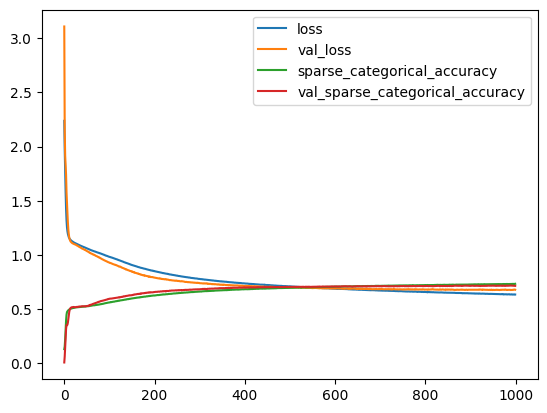

9255/9255 [==============================] - 41s 4ms/step


In [29]:
utils.plot_and_save_history(history,"./results/history_CNN_model_val_0f7151.png")

pred_y = CNN_model.predict(train_x)
pred_y = np.argmax(pred_y,axis=-1)

utils.plot_and_save_confusion_matrix(pred_y,train_y,"./results/confusion_matrix_CNN_model_val_0f7151.png")


### Send predictions

In [14]:
pred_y = CNN_model.predict(test_x)
pred_y = np.argmax(pred_y,axis=-1)
print("prediction on test set shape :", pred_y.shape)
print(pred_y)


######## Save results to submission file ########
print("--- save ---")
pred_df = pd.DataFrame(pred_y, columns=['change_type'])
pred_df.to_csv("my_submission.csv", index=True, index_label='Id')

3767/3767 [==============================] - 26s 7ms/step
prediction on test set shape : (120526,)
[3 3 3 ... 2 2 3]
--- save ---
